In [1]:
%cd 07_LPL_Data_Analysis
import os, json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

AUTO = tf.data.experimental.AUTOTUNE

np.random.seed(1001)
tf.random.set_seed(1001)

E:\ProjectFiles\Python\04_DeepLearning\07_LPL_Data_Analysis


In [26]:
data = pd.read_csv("./data/data.csv", index_col="result_id")
player_info = pd.read_csv('./data/Player_Info.csv', index_col="player_id")
hero_info = pd.read_csv('./data/Hero_Info.csv', index_col="hero_id")

def getEDcoder(data):
    encoder = {value: i for i, value in enumerate(data)}
    decoder = {i: value for i, value in enumerate(data)}
    return encoder, decoder
player_encoder, player_decoder = getEDcoder(player_info.index)
hero_encoder, hero_decoder = getEDcoder(hero_info.index)


In [21]:
def normalize(df):
    for col in df:
        df[col] = df[col] / df[col].max()
    return df
player_info = normalize(player_info)
hero_info = normalize(hero_info)

In [16]:
player_encoder[755103] = None

In [27]:
columns = list(data.columns)
for i, col in enumerate(columns):
    if col.startswith("red") and col != "red_result":
        columns[i] = col.replace("red", "blue")
    elif col.startswith("blue"):
        columns[i] = col.replace("blue", "red")
    if 'hero' in col:
        data[col] = data[col].map(lambda x: hero_encoder[x])
    elif 'player' in col:
        data[col] = data[col].map(lambda x: player_encoder[x])

data = data.dropna()
data2 = data[columns]
data2.columns = data.columns
data2["red_result"] = 1 - data["red_result"]
# data = pd.concat([data,data2])

KeyError: 2127103

In [24]:
data

,red_result,red_star_a_playerID,red_star_b_playerID,red_star_c_playerID,red_star_d_playerID,red_star_e_playerID,blue_star_a_playerID,blue_star_b_playerID,blue_star_c_playerID,blue_star_d_playerID,...,red_hero_a_heroID,red_hero_b_heroID,red_hero_c_heroID,red_hero_d_heroID,red_hero_e_heroID,blue_hero_a_heroID,blue_hero_b_heroID,blue_hero_c_heroID,blue_hero_d_heroID,blue_hero_e_heroID
result_id,,,,,,,,,,,,,,,,,,,,,
12890,1,30.0,33.0,17.0,10.0,60.0,55.0,70.0,53.0,18.0,...,7.0,65.0,13.0,11.0,1.0,10.0,25.0,21.0,8.0,71.0
13983,1,8.0,14.0,3.0,4.0,22.0,62.0,50.0,58.0,29.0,...,30.0,47.0,97.0,36.0,6.0,10.0,3.0,44.0,0.0,40.0
16196,0,461.0,455.0,469.0,452.0,468.0,447.0,428.0,451.0,429.0,...,783.0,771.0,772.0,775.0,765.0,777.0,781.0,768.0,776.0,782.0
19801,0,570.0,568.0,571.0,565.0,587.0,615.0,590.0,581.0,585.0,...,1057.0,1010.0,1013.0,1009.0,1015.0,1028.0,1019.0,1016.0,1022.0,1119.0
20939,0,883.0,851.0,839.0,855.0,867.0,881.0,868.0,820.0,825.0,...,1549.0,1570.0,1582.0,1543.0,1622.0,1575.0,1548.0,1553.0,1545.0,1552.0
21042,0,879.0,888.0,885.0,882.0,873.0,845.0,799.0,808.0,796.0,...,1579.0,1548.0,1561.0,1545.0,1568.0,1549.0,1546.0,1551.0,1543.0,1552.0
21191,0,845.0,799.0,808.0,796.0,819.0,869.0,806.0,813.0,802.0,...,1544.0,1548.0,1564.0,1545.0,1568.0,1566.0,1547.0,1594.0,1543.0,1550.0
21566,0,869.0,806.0,813.0,802.0,822.0,883.0,851.0,839.0,855.0,...,1566.0,1548.0,1564.0,1541.0,1560.0,1549.0,1603.0,1578.0,1543.0,1550.0
21085,1,948.0,939.0,941.0,935.0,937.0,936.0,942.0,933.0,915.0,...,1674.0,1693.0,1668.0,1664.0,1698.0,1684.0,1699.0,1764.0,1662.0,1687.0


In [19]:
def show_history(history):
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(history.history['loss'][10:])
    plt.plot(history.history['val_loss'][10:])
    plt.legend(['train', 'val'])       
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'][10:])
    plt.plot(history.history['val_accuracy'][10:])
    plt.legend(['train', 'val']) 

### 英雄和选手输入数据处理

In [ ]:
BATCH = 32
VAL_SPLIT = 0.05

def processData(data):
    data = tf.data.Dataset.from_tensor_slices(((data[:,1:11],data[:,11:]),data[:,0]))
    data = data.shuffle(2000).batch(BATCH).prefetch(AUTO)
    return data

val_data = data.sample(frac=VAL_SPLIT)
train_data = data.drop(val_data.index)
val_data = processData(val_data.values)
train_data = processData(train_data.values)

### 选手输入数据处理

In [20]:
BATCH = 32
VAL_SPLIT = 0.05

def processData(data):
    data = tf.data.Dataset.from_tensor_slices((data[:,1:11],data[:,0]))
    data = data.shuffle(2000).batch(BATCH).prefetch(AUTO)
    return data

val_data = data.sample(frac=VAL_SPLIT)
train_data = data.drop(val_data.index)
val_data = processData(val_data.values)
train_data = processData(train_data.values)

In [21]:
PLAYER_EMBED = len(player_encoder)
HERO_EMBED = len(hero_encoder)

## 可收敛模型，200epoch，但部分过拟合，最后使用Softmax作为激活函数的效果好于Sigmiod

In [ ]:
DROPOUT = 0.1
def resBlock(x, dim):
    branch = x
    x = keras.layers.Dense(dim, activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(2 * dim, activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(branch.shape[-1], activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.ReLU()(x + branch)
    return x

def build_model(num_res, dim):
    players = tf.keras.layers.Input(10)
    players_ = tf.cast(players, 'int32')
    players_ = tf.one_hot(players_, depth=PLAYER_EMBED)
    heros = tf.keras.layers.Input(10)
    heros_ = tf.cast(heros, 'int32')
    heros_ = tf.one_hot(heros_, depth=HERO_EMBED)

    player_emb = tf.matmul(players_, player_info.values)
    hero_emb = tf.matmul(heros_, hero_info.values)
    
    x = tf.concat([player_emb, hero_emb], axis=-1)
    x = keras.layers.Flatten()(x)
    
    branch = x
    for _ in range(num_res):
        x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    branch = x
    for _ in range(num_res):
        x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    branch1 = x
    for _ in range(num_res):
        x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch1)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    x = keras.layers.Dense(dim)(x)
    out = tf.keras.layers.Dense(2,activation='softmax')(x)

    return tf.keras.Model(inputs=[players,heros],outputs=out)

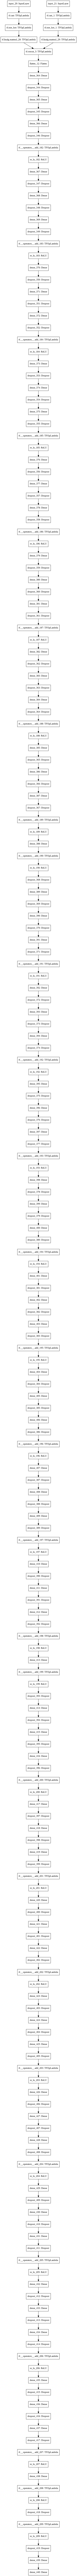

In [ ]:
plot_model(build_model(8, 64))

In [ ]:
model = build_model(8, 64)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10,
    decay_rate=0.5)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = "adam",
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy")
history = model.fit(train_data, validation_data=val_data,epochs=400)

Epoch 1/400
273/273 [==============================] - 13s 26ms/step - loss: 1.0645 - accuracy: 0.6306 - val_loss: 0.5758 - val_accuracy: 0.7101
Epoch 2/400
273/273 [==============================] - 7s 24ms/step - loss: 0.5878 - accuracy: 0.6912 - val_loss: 0.5627 - val_accuracy: 0.7267
Epoch 3/400
273/273 [==============================] - 6s 24ms/step - loss: 0.5746 - accuracy: 0.6997 - val_loss: 0.5589 - val_accuracy: 0.7246
Epoch 4/400
273/273 [==============================] - 6s 23ms/step - loss: 0.5717 - accuracy: 0.7016 - val_loss: 0.5426 - val_accuracy: 0.7329
Epoch 5/400
273/273 [==============================] - 6s 23ms/step - loss: 0.5648 - accuracy: 0.7074 - val_loss: 0.5347 - val_accuracy: 0.7246
Epoch 6/400
273/273 [==============================] - 6s 23ms/step - loss: 0.5607 - accuracy: 0.7112 - val_loss: 0.5301 - val_accuracy: 0.7267
Epoch 7/400
273/273 [==============================] - 6s 23ms/step - loss: 0.5575 - accuracy: 0.7172 - val_loss: 0.5367 - val_accuracy

In [ ]:
model = build_model(4, 64)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10,
    decay_rate=0.5)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = keras.optimizers.RMSprop(3e-5),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy")
history = model.fit(train_data, validation_data=val_data,epochs=200)

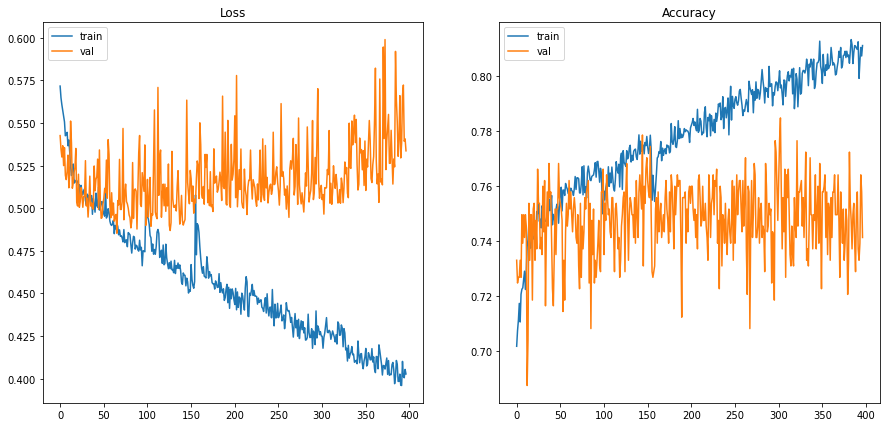

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history.history['loss'][3:])
plt.plot(history.history['val_loss'][3:])
plt.legend(['train', 'val'])       
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(history.history['accuracy'][3:])
plt.plot(history.history['val_accuracy'][3:])
plt.legend(['train', 'val'])    

In [ ]:
model.save(f'model_loss-{history.history["loss"][-1]:.4f}_accu-{history.history["accuracy"][-1]:.4f}_valLoss-{history.history["val_loss"][-1]:.4f}_valAccu-{history.history["val_accuracy"][-1]:.4f}')

INFO:tensorflow:Assets written to: model_loss-0.4028_accu-0.8110_valLoss-0.5337_valAccu-0.7412/assets


In [ ]:
!zip -r result.zip "/content/drive/MyDrive/Colab Notebooks/LOL_S11Predict/model_loss-0.4028_accu-0.8110_valLoss-0.5337_valAccu-0.7412/"


  adding: content/drive/MyDrive/Colab Notebooks/LOL_S11Predict/model_loss-0.4028_accu-0.8110_valLoss-0.5337_valAccu-0.7412/ (stored 0%)
  adding: content/drive/MyDrive/Colab Notebooks/LOL_S11Predict/model_loss-0.4028_accu-0.8110_valLoss-0.5337_valAccu-0.7412/assets/ (stored 0%)
  adding: content/drive/MyDrive/Colab Notebooks/LOL_S11Predict/model_loss-0.4028_accu-0.8110_valLoss-0.5337_valAccu-0.7412/variables/ (stored 0%)
  adding: content/drive/MyDrive/Colab Notebooks/LOL_S11Predict/model_loss-0.4028_accu-0.8110_valLoss-0.5337_valAccu-0.7412/variables/variables.data-00000-of-00001 (deflated 65%)
  adding: content/drive/MyDrive/Colab Notebooks/LOL_S11Predict/model_loss-0.4028_accu-0.8110_valLoss-0.5337_valAccu-0.7412/variables/variables.index (deflated 82%)
  adding: content/drive/MyDrive/Colab Notebooks/LOL_S11Predict/model_loss-0.4028_accu-0.8110_valLoss-0.5337_valAccu-0.7412/saved_model.pb (deflated 80%)
  adding: content/drive/MyDrive/Colab Notebooks/LOL_S11Predict/model_loss-0.4028

## 模型二

In [ ]:
DROPOUT = 0.1
def resBlock(x, dim):
    branch = x
    x = keras.layers.Dense(dim, activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(2 * dim, activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(branch.shape[-1], activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.ReLU()(x + branch)
    return x

def build_model1(num_res, in_num, dim):
    players = tf.keras.layers.Input(10)
    players_ = tf.cast(players, 'int32')
    players_ = tf.one_hot(players_, depth=PLAYER_EMBED)
    heros = tf.keras.layers.Input(10)
    heros_ = tf.cast(heros, 'int32')
    heros_ = tf.one_hot(heros_, depth=HERO_EMBED)

    player_emb = tf.matmul(players_, player_info.values)
    hero_emb = tf.matmul(heros_, hero_info.values)
    
    x = tf.concat([player_emb, hero_emb], axis=-1)
    x = keras.layers.Flatten()(x)
    
    branch = x
    for _ in range(num_res):
        x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
  
    # bigeest Res Start
    branch = x
    for _ in range(num_res):
        x = resBlock(x, dim)
        
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    for i in range(in_num):
       
        
        # inner Res Start
        banch_in = x
        
        for _ in range(num_res):
            # minist Res
            x = resBlock(x, dim)
        
        # inner Res End
        x = keras.layers.Dense(x.shape[-1])(x)
        x = keras.layers.ReLU()(x + banch_in)
        x = keras.layers.Dropout(DROPOUT)(x)
        
    
    # biggest Res End
    x = x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    x = keras.layers.Dense(dim)(x)
    out = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    return tf.keras.Model(inputs=[players,heros],outputs=out)

### 比较不同残差块数量和模型规模的区别

In [ ]:
result = {"Loss": {},
      "Accuracy": {},
      "Val_Loss": {},
      "Val_Accuracy": {}}

for n in (6, 8, 12):
    for d in (1,2,3):
      for dim in (32, 64, 96):
        model = build_model1(n, d, dim)
        model.compile(optimizer = "adam",
                      loss="binary_crossentropy",
                      metrics="accuracy")
        history = model.fit(train_data, validation_data=val_data,epochs=15)
        for key in result:
            result[key].update({f"InRes_{n} MidRes_{d} Dim_{dim}":history.history[key.lower()]})

Epoch 1/15
273/273 [==============================] - 11s 23ms/step - loss: 0.7559 - accuracy: 0.6283 - val_loss: 0.6185 - val_accuracy: 0.6687
Epoch 2/15
273/273 [==============================] - 6s 21ms/step - loss: 0.5901 - accuracy: 0.6895 - val_loss: 0.5803 - val_accuracy: 0.6957
Epoch 3/15
273/273 [==============================] - 6s 21ms/step - loss: 0.5812 - accuracy: 0.6956 - val_loss: 0.6013 - val_accuracy: 0.6874
Epoch 4/15
273/273 [==============================] - 6s 21ms/step - loss: 0.5711 - accuracy: 0.7080 - val_loss: 0.5749 - val_accuracy: 0.7039
Epoch 5/15
273/273 [==============================] - 6s 20ms/step - loss: 0.5727 - accuracy: 0.7022 - val_loss: 0.5575 - val_accuracy: 0.7101
Epoch 6/15
273/273 [==============================] - 6s 21ms/step - loss: 0.5675 - accuracy: 0.7096 - val_loss: 0.5608 - val_accuracy: 0.7164
Epoch 7/15
273/273 [==============================] - 6s 21ms/step - loss: 0.5628 - accuracy: 0.7084 - val_loss: 0.5717 - val_accuracy: 0.720

貌似是midRes x InRes = 12时效果比较好，使用2 x 6，dim=96进行训练

In [ ]:
def draw(data):
    legend = list(filter(lambda i: i.endswith("Dim_96"), list(data[list(data.keys())[0]].keys())))
    plt.figure(figsize=(15,15))
    for i, key in enumerate(data):
        plt.subplot(2,2,i+1)
        plt.title(key)
        for item in data[key]:
          if item.endswith("Dim_96"):
            plt.plot(data[key][item][3:])
        plt.legend(legend) 
draw(result)       

### 训练模型

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=200,
    decay_rate=0.1)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
model = build_model1(6, 3, 64)
model.compile(optimizer = keras.optimizers.Adam(5e-4),
        loss="binary_crossentropy",
        metrics="accuracy")
history = model.fit(train_data, validation_data=val_data,epochs=400)

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.legend(['train', 'val'])       
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(history.history['accuracy'][10:])
plt.plot(history.history['val_accuracy'][10:])
plt.legend(['train', 'val'])    

In [ ]:
model = build_model1(10, 1, 64)
model.compile(optimizer = keras.optimizers.Adam(5e-4),
        loss="binary_crossentropy",
        metrics="accuracy")
history2 = model.fit(train_data, validation_data=val_data,epochs=200)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history2.history['loss'][10:])
plt.plot(history2.history['val_loss'][10:])
plt.legend(['train', 'val'])       
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(history2.history['accuracy'][10:])
plt.plot(history2.history['val_accuracy'][10:])
plt.legend(['train', 'val']) 

## 红蓝队伍分开进行预测

In [27]:
DROPOUT = 0.1
def resBlock(x, dim):
    branch = x
    x = keras.layers.Dense(dim, activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(branch.shape[-1], activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.ReLU()(x + branch)
    return x

def baseModel(num_res, dim):
    inputs = keras.layers.Input(5, dtype="int32")
    players = tf.one_hot(inputs, depth = PLAYER_EMBED, axis=-1)
    player_emb = tf.matmul(players, player_info.values)

    x = keras.layers.Flatten()(player_emb)

    branch = x
    for _ in range(num_res):
        x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    for _ in range(num_res):
        x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)

    x = keras.layers.Dense(dim, activation="relu")(x)
    out = keras.layers.Dense(1)(x)
    return keras.Model(inputs=inputs, outputs = out)

def build_model(num_res, dim):
    players = keras.layers.Input(10, dtype="int32")
    red = players[:, :5]
    blue = players[:, 5:]
    red_model = baseModel(num_res, dim)
    blue_model = baseModel(num_res, dim)
    red_out = red_model(red)
    blue_out = blue_model(blue)

    x = tf.concat([red_out, blue_out], axis=-1)
    out = keras.layers.Softmax()(x)

    return tf.keras.Model(inputs=players,outputs=out)

In [28]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.001, patience=15)

model = build_model(12, 64)
model.compile(optimizer = keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy")
history = model.fit(train_data, validation_data=val_data,epochs=200, callbacks=[early_stop])

Epoch 1/200
273/273 [==============================] - 20s 57ms/step - loss: 3.5390 - accuracy: 0.5482 - val_loss: 0.6262 - val_accuracy: 0.6853
Epoch 2/200
273/273 [==============================] - 15s 55ms/step - loss: 0.6700 - accuracy: 0.6028 - val_loss: 0.6080 - val_accuracy: 0.7164
Epoch 3/200
273/273 [==============================] - 15s 55ms/step - loss: 0.6342 - accuracy: 0.6403 - val_loss: 0.5876 - val_accuracy: 0.7164
Epoch 4/200
273/273 [==============================] - 15s 55ms/step - loss: 0.6263 - accuracy: 0.6463 - val_loss: 0.5841 - val_accuracy: 0.7039
Epoch 5/200
273/273 [==============================] - 15s 55ms/step - loss: 0.6131 - accuracy: 0.6654 - val_loss: 0.5868 - val_accuracy: 0.6853
Epoch 6/200
273/273 [==============================] - 15s 56ms/step - loss: 0.6106 - accuracy: 0.6662 - val_loss: 0.5674 - val_accuracy: 0.7246
Epoch 7/200
273/273 [==============================] - 15s 56ms/step - loss: 0.6021 - accuracy: 0.6713 - val_loss: 0.5692 - val_ac

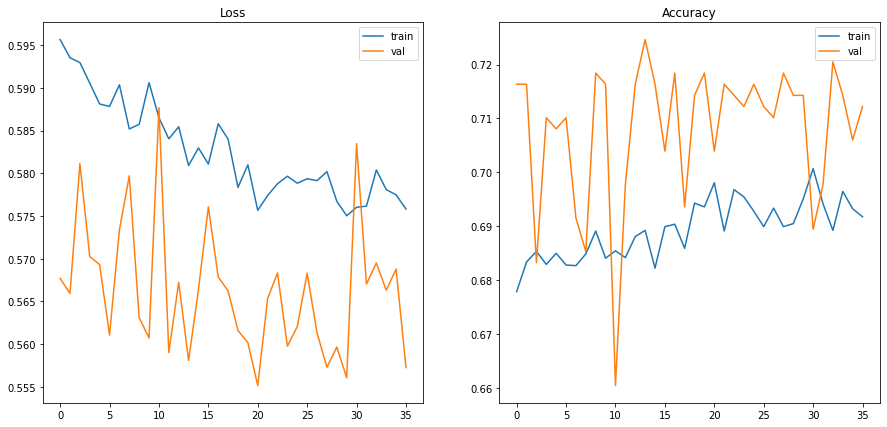

In [29]:
show_history(history)

In [ ]:
model.save(f'model_loss-{history.history["loss"][-1]:.4f}_accu-{history.history["accuracy"][-1]:.4f}_valLoss-{history.history["val_loss"][-1]:.4f}_valAccu-{history.history["val_accuracy"][-1]:.4f}.h5')

In [31]:
def baseModel(num_res, dim):
    inputs = keras.layers.Input(5, dtype="int32")
    players = tf.one_hot(inputs, depth = PLAYER_EMBED, axis=-1)
    player_emb = tf.matmul(players, player_info.values)

    x = keras.layers.Flatten()(player_emb)

    x = keras.layers.Dense(dim, activation="sigmoid")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(dim, activation="sigmoid")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    out = keras.layers.Dense(1)(x)
    return keras.Model(inputs=inputs, outputs = out)

def build_model(num_res, dim):
    players = keras.layers.Input(10, dtype="int32")
    red = players[:, :5]
    blue = players[:, 5:]
    red_model = baseModel(num_res, dim)
    blue_model = baseModel(num_res, dim)
    red_out = red_model(red)
    blue_out = blue_model(blue)

    x = tf.concat([red_out, blue_out], axis=-1)
    out = keras.layers.Softmax()(x)

    return tf.keras.Model(inputs=players,outputs=out)

In [34]:
model2 = build_model(12, 64)
model2.compile(optimizer = keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy")
history2 = model2.fit(train_data, validation_data=val_data,epochs=200, callbacks=[early_stop])

Epoch 1/200
273/273 [==============================] - 2s 5ms/step - loss: 0.6937 - accuracy: 0.5349 - val_loss: 0.6396 - val_accuracy: 0.6977
Epoch 2/200
273/273 [==============================] - 1s 4ms/step - loss: 0.6244 - accuracy: 0.6443 - val_loss: 0.5730 - val_accuracy: 0.7143
Epoch 3/200
273/273 [==============================] - 1s 4ms/step - loss: 0.5988 - accuracy: 0.6741 - val_loss: 0.5625 - val_accuracy: 0.7122
Epoch 4/200
273/273 [==============================] - 1s 4ms/step - loss: 0.5858 - accuracy: 0.6822 - val_loss: 0.5886 - val_accuracy: 0.6853
Epoch 5/200
273/273 [==============================] - 1s 4ms/step - loss: 0.5854 - accuracy: 0.6863 - val_loss: 0.5592 - val_accuracy: 0.7143
Epoch 6/200
273/273 [==============================] - 1s 4ms/step - loss: 0.5858 - accuracy: 0.6865 - val_loss: 0.5568 - val_accuracy: 0.7184
Epoch 7/200
273/273 [==============================] - 1s 4ms/step - loss: 0.5805 - accuracy: 0.6933 - val_loss: 0.5600 - val_accuracy: 0.7205

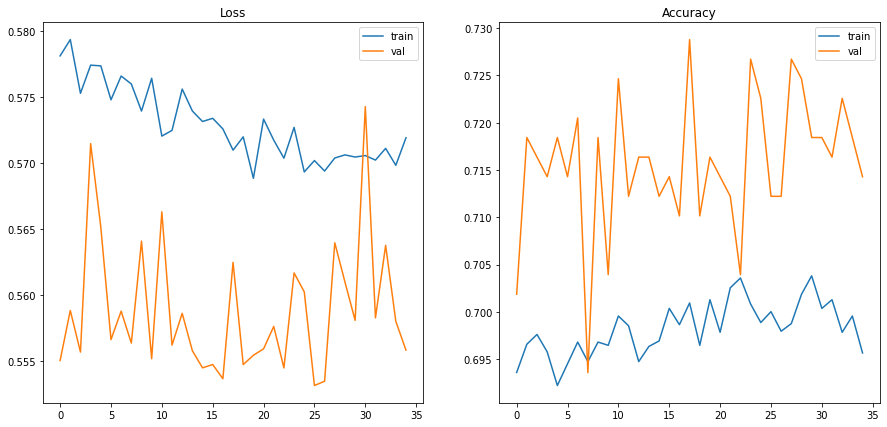

In [35]:
show_history(history2)

#### 红蓝队伍分开预测，使用embedding

In [36]:
DROPOUT = 0.1
def resBlock(x, dim):
    branch = x
    x = keras.layers.Dense(dim, activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(branch.shape[-1], activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.ReLU()(x + branch)
    return x

def attention(q, k, v):
    atten = tf.nn.softmax(tf.matmul(q, k, transpose_b=True),axis=-1)
    v = tf.matmul(atten, v)
    return v

def baseModel(num_res, dim):
    inputs = keras.layers.Input((5, 15))

    x = keras.layers.Flatten()(inputs)

    branch = x
    for _ in range(num_res):
      x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    for _ in range(num_res):
      x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)

    x = keras.layers.Dense(dim, activation="relu")(x)
    out = keras.layers.Dense(1)(x)
    return keras.Model(inputs=inputs, outputs = out)

def build_model(num_res, dim):
    players = keras.layers.Input(10, dtype="int32")
    players_ = tf.one_hot(players, depth=PLAYER_EMBED)
    player_emb = tf.matmul(players_, player_info.values)

    red = player_emb[:, :5]
    blue = player_emb[:, 5:]
    red = attention(red, blue, red)
    blue = attention(blue, red, blue)

    red_model = baseModel(num_res, dim)
    blue_model = baseModel(num_res, dim)
    red_out = red_model(red)
    blue_out = blue_model(blue)

    x = tf.concat([red_out, blue_out], axis=-1)
    out = keras.layers.Softmax()(x)

    return tf.keras.Model(inputs=players,outputs=out)


In [84]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.001, patience=15)

model = build_model(8, 96)
model.compile(optimizer = keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy")
history = model.fit(train_data, validation_data=val_data,epochs=200)

Epoch 1/200
273/273 [==============================] - 41s 25ms/step - loss: 0.7546 - accuracy: 0.5991 - val_loss: 0.5670 - val_accuracy: 0.7205
Epoch 2/200
273/273 [==============================] - 6s 23ms/step - loss: 0.6177 - accuracy: 0.6593 - val_loss: 0.5975 - val_accuracy: 0.6480
Epoch 3/200
273/273 [==============================] - 6s 22ms/step - loss: 0.6097 - accuracy: 0.6659 - val_loss: 0.5481 - val_accuracy: 0.7205
Epoch 4/200
273/273 [==============================] - 6s 23ms/step - loss: 0.6046 - accuracy: 0.6753 - val_loss: 0.5827 - val_accuracy: 0.6770
Epoch 5/200
273/273 [==============================] - 6s 23ms/step - loss: 0.5924 - accuracy: 0.6831 - val_loss: 0.5566 - val_accuracy: 0.7329
Epoch 6/200
273/273 [==============================] - 6s 23ms/step - loss: 0.5918 - accuracy: 0.6888 - val_loss: 0.5555 - val_accuracy: 0.7308
Epoch 7/200
273/273 [==============================] - 6s 23ms/step - loss: 0.5924 - accuracy: 0.6781 - val_loss: 0.5587 - val_accuracy

KeyboardInterrupt: ignored

In [ ]:
show_history(history)

In [43]:
DROPOUT = 0.0
def resBlock(x, dim):
    branch = x
    x = keras.layers.Dense(dim, activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(branch.shape[-1], activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.ReLU()(x + branch)
    return x

def attention(q, k, v):
    atten = tf.nn.softmax(tf.matmul(q, k, transpose_b=True),axis=-1)
    v = tf.matmul(atten, v)
    return v

def baseModel(num_res, dim):
    inputs = keras.layers.Input((5, 16))

    x = keras.layers.Flatten()(inputs)

    x = keras.layers.Dense(128, activation="sigmoid")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    x = keras.layers.Dense(128, activation="sigmoid")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(DROPOUT)(x)

    out = keras.layers.Dense(1)(x)
    return keras.Model(inputs=inputs, outputs = out)

def build_model(num_res, dim):
    players = keras.layers.Input(10, dtype="int32")
    players_ = tf.one_hot(players, depth=PLAYER_EMBED)
    player_emb1 = tf.matmul(players_, player_info.values)

    emblayer = keras.layers.Embedding(PLAYER_EMBED, 1)

    red1 = emblayer(players[:, :5])
    blue1 = emblayer(players[:, :5])
    
    red = tf.concat([red1, player_emb1[:,:5]], axis=-1)
    red = keras.layers.BatchNormalization()(red)
    blue = tf.concat([blue1, player_emb1[:,5:]], axis=-1)
    blue = keras.layers.BatchNormalization()(blue)

    red = attention(red, blue, red)
    blue = attention(blue, red, blue)

    red_model = baseModel(num_res, dim)
    blue_model = baseModel(num_res, dim)
    red_out = red_model(red)
    blue_out = blue_model(blue)

    x = tf.concat([red_out, blue_out], axis=-1)
    out = keras.layers.Softmax()(x)

    return tf.keras.Model(inputs=players,outputs=out)

model2 = build_model(8, 64)
model2.compile(optimizer = keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy")
history2 = model2.fit(train_data, validation_data=val_data,epochs=100, callbacks=[early_stop])
show_history(history2)

Epoch 1/100
273/273 [==============================] - 4s 13ms/step - loss: 0.6632 - accuracy: 0.6533 - val_loss: 0.6208 - val_accuracy: 0.6749
Epoch 2/100
273/273 [==============================] - 3s 12ms/step - loss: 0.6108 - accuracy: 0.6672 - val_loss: 0.6001 - val_accuracy: 0.6729
Epoch 3/100
273/273 [==============================] - 3s 12ms/step - loss: 0.5907 - accuracy: 0.6850 - val_loss: 0.5854 - val_accuracy: 0.6998
Epoch 4/100
273/273 [==============================] - 3s 12ms/step - loss: 0.5799 - accuracy: 0.6888 - val_loss: 0.5937 - val_accuracy: 0.6874
Epoch 5/100
273/273 [==============================] - 3s 12ms/step - loss: 0.5767 - accuracy: 0.6931 - val_loss: 0.5949 - val_accuracy: 0.6957
Epoch 6/100
273/273 [==============================] - 3s 13ms/step - loss: 0.5681 - accuracy: 0.7008 - val_loss: 0.6194 - val_accuracy: 0.6542
Epoch 7/100
273/273 [==============================] - 3s 13ms/step - loss: 0.5610 - accuracy: 0.7086 - val_loss: 0.6049 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
model.save(f'model_loss-{history.history["loss"][-1]:.4f}_accu-{history.history["accuracy"][-1]:.3f}_valLoss-{history.history["val_loss"][-1]:.4f}_valAccu-{history.history["val_accuracy"][-1]:.3f}.h5')